( I tried running this, direct from the authors repo, the only needed change is to the data_path, and comment out the summary ... this too blew up while training, epoch 7 ... the same as my version of this. sigh.)

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()


In [2]:
# docker container start hfpt_sept1

# Friday, Sept 1, 2023
# OK so the problem is this notebook runs out of memory ... 
# I watched it climb to almost 32gb at around epoch 10 ... but then interrupted the kernel because I knew
# it would fail ... Current swap file size is only 2g ... this needs to increase to at least 16g ...

# OK ... Swapfile is now at 16gb ... so lets give this another go, shall we ... 
# Interesting ... I was watching the memory allocation while running this notebook, and it was at almost 
# 32gb in epoch 7 ... AND it looks like I need to increase the swapfile size to 32gb ... so gonna do that
# and then run this again ...

# OK ... swapfile is at 32gb ... I interrupted the kernel at epoch 13 cuz swapfile is at 25.9gb and I am pretty
# sure its gonna fail before finishing after epoch 15 ... So the solution is to run this with fewer epochs or
# again increase swap size ... I am gonna go with descreasing epochs to 12 ... so lets try this one final
# time, shall we ... 

# OK ... it runs if only 12 epochs ... good enough for me!

# only target the 2070 Super ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Version 4 - Adding Augmentations, Batch Norm, Regularizers

## 1. Imports

In [3]:
# !pip install opencv-python

In [4]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
# from torchsummary import summary
from tqdm import tqdm

## 2. Setup data

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [6]:
## set the path to train and test set
# data_path = ## drive location
## for colab set the folders in colab root folder

#!unzip <zip file location>
data_path = '/content/chest_xray'

data_path = '/tf/All/Data/Kaggle/Chest_X-ray_Images'

## 3. Explore data

In [7]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [8]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1380, 1682)


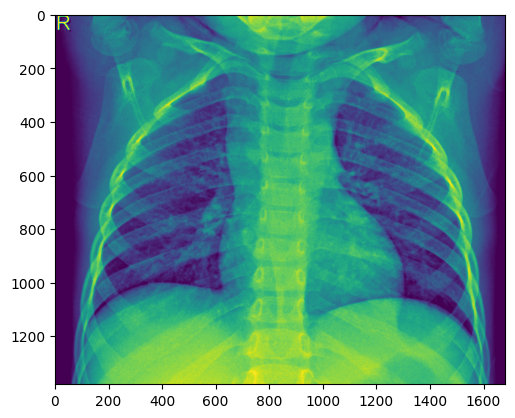

In [9]:
## get random file to check
img = data_path + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(712, 1088)


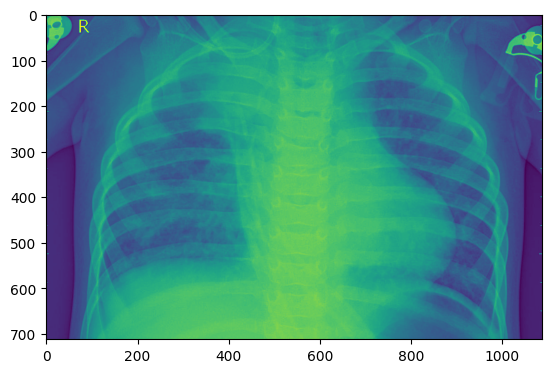

In [10]:
## get random file to check pneumona 
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [11]:
train_transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [12]:
## getting train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 16, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data, 
                         batch_size= 1, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## 4. Define Model

In [13]:

import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) 

        self.pool22 = nn.MaxPool2d(2, 2) 


        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(10),
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32),
           
        ) 


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14)
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [14]:
# this grabs 102MiB of vram ...
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
# summary(model, input_size=(3, 224, 224))

Available processor cuda


## 5. Training

In [15]:


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        for p in model.parameters():
            l1=l1+p.abs().sum()
        loss = loss+lambda1*l1

        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))


In [16]:


model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
# reduce to 12 ....
EPOCHS = 12

for epoch in range(EPOCHS):
    print("EPOCH number:", epoch)
    train(model, device, train_loader, optimizer, epoch,l1=0,lambda1 = 10e-4)
    scheduler.step()
    print('Current Learing Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH number: 0


Loss=0.631830632686615 Batch_id=326 Accuracy=90.25: 100%|█| 327/327 [01:19<00:00


Current Learing Rate:  0.01

Test set: Average loss: 1.0468, Accuracy: 449/624 (71.96%)

EPOCH number: 1


Loss=0.5019407272338867 Batch_id=326 Accuracy=93.52: 100%|█| 327/327 [01:19<00:0


Current Learing Rate:  0.01

Test set: Average loss: 0.5221, Accuracy: 504/624 (80.77%)

EPOCH number: 2


Loss=0.5019054412841797 Batch_id=326 Accuracy=93.37: 100%|█| 327/327 [01:21<00:0


Current Learing Rate:  0.01

Test set: Average loss: 0.2945, Accuracy: 550/624 (88.14%)

EPOCH number: 3


Loss=0.4812878966331482 Batch_id=326 Accuracy=93.71: 100%|█| 327/327 [01:19<00:0


Current Learing Rate:  0.01

Test set: Average loss: 0.4418, Accuracy: 498/624 (79.81%)

EPOCH number: 4


Loss=0.421491801738739 Batch_id=326 Accuracy=93.86: 100%|█| 327/327 [01:20<00:00


Current Learing Rate:  0.01

Test set: Average loss: 0.3762, Accuracy: 513/624 (82.21%)

EPOCH number: 5


Loss=0.7094074487686157 Batch_id=326 Accuracy=94.17: 100%|█| 327/327 [01:17<00:0


Current Learing Rate:  0.005

Test set: Average loss: 0.3212, Accuracy: 537/624 (86.06%)

EPOCH number: 6


Loss=0.3702312707901001 Batch_id=326 Accuracy=95.26: 100%|█| 327/327 [01:17<00:0


Current Learing Rate:  0.005

Test set: Average loss: 0.4412, Accuracy: 517/624 (82.85%)

EPOCH number: 7


Loss=0.4191683530807495 Batch_id=326 Accuracy=94.97: 100%|█| 327/327 [01:25<00:0


Current Learing Rate:  0.005

Test set: Average loss: 0.6494, Accuracy: 482/624 (77.24%)

EPOCH number: 8


Loss=0.3578982949256897 Batch_id=326 Accuracy=94.44: 100%|█| 327/327 [01:31<00:0


Current Learing Rate:  0.005

Test set: Average loss: 0.3968, Accuracy: 527/624 (84.46%)

EPOCH number: 9


Loss=0.2674456536769867 Batch_id=326 Accuracy=94.94: 100%|█| 327/327 [01:28<00:0


Current Learing Rate:  0.005

Test set: Average loss: 0.4268, Accuracy: 514/624 (82.37%)

EPOCH number: 10


Loss=0.28149503469467163 Batch_id=326 Accuracy=95.07: 100%|█| 327/327 [01:24<00:


Current Learing Rate:  0.005

Test set: Average loss: 0.4862, Accuracy: 499/624 (79.97%)

EPOCH number: 11


Loss=0.25811126828193665 Batch_id=326 Accuracy=95.03: 100%|█| 327/327 [01:28<00:


Current Learing Rate:  0.0025

Test set: Average loss: 0.3858, Accuracy: 523/624 (83.81%)



Text(0.5, 1.0, 'Test Accuracy')

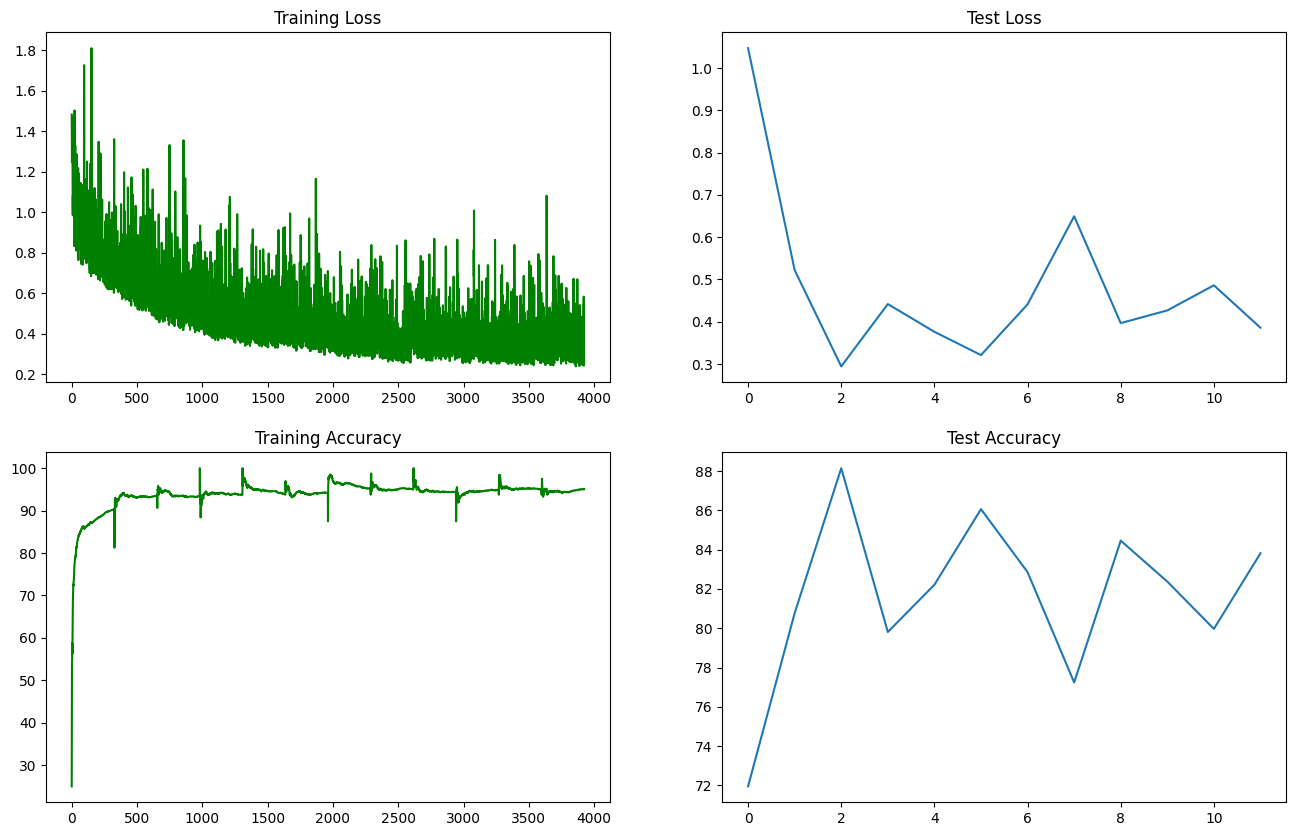

In [17]:

torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

In [18]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Friday, September 01, 2023
# Run Time: 00:18:24
